# Introduction to Machine Learning
## Home Assignment 1

In [25]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

In [26]:
# We get the data 
_URL = 'http://www.di.ens.fr/appstat/spring-2020/project/data.zip'

path_to_zip = tf.keras.utils.get_file('data.zip', origin=_URL, extract=True)

data_path = os.path.join(os.path.dirname(path_to_zip), 'data')

training_data_path = os.path.join(data_path, 'train')

test_data_path = os.path.join(data_path, 'test')

In [27]:
# We define the constants

number_of_letters = 6000
number_of_samples_per_letter = 2000
pixel_height = 28
pixel_width = 28
batch_size = 50
shape = (pixel_height*pixel_width)
seed = 54
# We define a flow of images: 

def generate (dir_path): 
    training_data = []
    training_labels = []
    for item in os.listdir(dir_path):
        tmp = os.path.join(dir_path,item)
        if os.path.isdir(tmp):
            d, l = generate (tmp)
            training_data = training_data + d
            training_labels = training_labels + l
        elif tmp[-3:] == "png":
            im = Image.open(tmp)
            training_data.append(np.reshape(np.asarray(im), shape))
            if(dir_path[-1:] == 'A'):
                training_labels.append(1)
            else: 
                training_labels.append(-1)
    return training_data, training_labels
            
def make (dir_path): 
    d, l = generate(dir_path)
    data = np.array(d)/255
    random.Random(seed).shuffle(data)
    label = np.reshape(np.array(l), (np.shape(l)[0],1))
    random.Random(seed).shuffle(label)
    return data, label



training_data, training_labels = make(training_data_path)
test_data, test_labels = make(test_data_path)

print(np.shape(training_data))
print(np.shape(training_labels))
    


(6000, 784)
(6000, 1)


1. Formalize the problem by defining the input space $X$ , the output space $Y$ and the training data set. What are their dimension?

Having preprocessed the data we are going to use the images as vectors of pixels with size $n = pixel\_width*pixel\_height$. Thus: \
$X$ is $[0, 1]^n$ and $Y$ is $\{-1, 1\}$ and $D = (X \times Y) $



2. a) What are the empirical risk (training error) and the true risk associated with the 0-1 loss? Why is it complicated to minimize the empirical risk in this case

The empirical risk for the 0-1 loss is : $$R_d(f) = \frac{1}{d} \sum_{i = 1}^{d} \mathbb{1}_{f(X_i) \neq Y_i}$$ and the true risk is : $$R(f) = \mathbb{E}\{\mathbb{1}_{f(X) \neq Y} | D \}$$
The empirical risk here is of the 0-1 loss function is non-convex and discontinuous, thus (sub)gradient methods cannot be applied. Any iterative method would be exponential in the input size thus the choice of the 0-1 loss would be inadequate.

2. b) Why should we use the test data to assess the performance ? 

Test data should be from the same statistical distribution as the training data, and should not have been fed to the learning model before (otherwise there is no point given the model already adjusted to that data before)

2. c) Recall the definition of the optimization problems associated with the linear least square regression andthe linear logistic regression.

We start firstly with linear regression: 
$$f_n\in argmin_{f \in \mathbb F}R_n(f) := argmin_{f \in \mathbb F}\frac{1}{n}\sum_{i = 1}^{n}l(x_i, y_i)$$
with $l$ being the loss function associated to the problem. 
In linear regression, we usually choose the square loss, and as the name states we choose a linear model: $f(x) = \theta^T x$. Thus the linear regression problem becomes: 
$$min_{\theta \in \mathbb R^n} R_n(\theta) := min_{\theta \in \mathbb R^n}\frac{1}{n}\sum_{i = 1}^{n}( \theta^T x_i - y_i)^2$$
That can simply be rewritten to: 
$$min_{\theta \in \mathbb R^n} R_n(\theta) := min_{\theta \in \mathbb R^n} \frac{1}{n} || Y - X\theta ||_2^2 $$
with $X \in \mathbb R^{d*n}$ being the design matrix having at the row $i$ $x_i^T$, and $Y \in \mathbb R^d$ being the vector of outputs with $y_i$ at the position $i$

For logistic regression we have: 
$$f_n\in argmin_{f \in \mathbb F}R_n(f) := argmin_{f \in \mathbb F}\frac{1}{n}\sum_{i = 1}^{n}l(x_i, y_i)$$
with $l$ being the loss function associated to the problem. 
In logistic regression, we try to maximize the log-likelihood of an estimator and we end up with a minimization problem using the logistic loss, we choose a linear model: $f(x) = \theta^T x$. Thus the logistic regression problem becomes: 

$$min_{\theta \in \mathbb R^n} R_n(\theta) := min_{\theta \in \mathbb R^n}\frac{1}{n}\sum_{i = 1}^{n}log(1 + e^{−y_i \theta^T x_i}))$$


In [51]:
#we define here some utility functions to compute the regression sum and the gradient

def logistic_loss (theta, x, y): 
    return 1/np.shape(y)[0] * np.sum(np.log(1+np.exp(-y*x@theta)), axis=0)

def logistic_gradient (theta, x, y):
    k = -y*x
    e = np.exp(k@theta)
    u_ = k*e
    return np.reshape(1/np.shape(y)[0] * np.sum(u_/(1+e), axis=0), np.shape(theta)) 


def square_loss (theta, x, y): 
    return 1/np.shape(y)[0] * np.sum((x@theta - y)**2, axis=0)

def square_gradient (theta, x, y):
    return np.reshape(1/np.shape(y)[0]*2*np.sum(x, axis=0)*square_loss(theta, x, y), np.shape(theta))           
    
def sigmoid(t):
    return 1/(1 + np.exp(-t))       

def logistic_classify(theta, data): 
    return 2*(sigmoid(data@theta)>0.5) - 1

def square_classify(theta, data): 
    return 2*(data@theta > 0) - 1

def test(theta, data_set, labels, classify): 
    accuracy = 0
    for x, y in zip (data_set, labels):
        accuracy += (classify(theta, x) == y) 
    return accuracy/len(labels)

def plot(training_error, test_error, t):
    plt.plot(t, training_error)
    plt.plot(t, test_error)
    plt.show(block=False)

[-33.87820466]
[-30.01075433]
[-30.01075433]
[-30.01075433]
[-30.01075423]
[-16.18546042]
[-2.94288746e-11]
[9.41346212]
[-9.4134442]
[-7.25123022e-09]
[-7.24566927e-09]
[-7.2401152e-09]
[-1.88842443e-05]
[1.71432145]
[-1.71432145]
[0.]
[0.]
[0.]
[0.00033835]
[-2.32290707e-06]
[-0.00033601]
[-2.02060587e-14]
[0.00358637]
[-0.00031848]
[-0.00026558]
[-0.00022499]
[-0.00019313]
[-0.00016765]
[-0.00014694]
[-0.00012988]
[-0.00011564]
[-0.00010365]
[-9.34384472e-05]
[-0.00158788]
[-1.16171369e-06]
[-0.00023798]
[0.]
[0.00023683]
[-1.13938737e-06]
[-0.00023569]
[0.]
[0.]
[0.]
[47.00576949]
[-37.25498673]
[-9.75078276]
[0.]
[-1.13753451e-12]
[0.]
[0.]
[0.]
[1.13753451e-12]
[-1.13753451e-12]
[0.]
[0.]
[0.]
[0.]
[2.95319325e-13]
[-2.95319325e-13]
[0.]
[0.]
[0.]
[2.95319325e-13]
[-2.95319325e-13]
[0.]
[0.]
[0.]
[5.88565177e-08]
[-5.88565177e-08]
[0.]
[0.]
[0.]
[0.]
[3.10166981e-09]
[-2.22044605e-16]
[-3.10166958e-09]
[5.88564888e-08]
[-5.88564888e-08]
[0.]
[0.]
[2.95319325e-13]
[-2.95319325e-13

[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.55586655e-12]
[1.88251636e-11]
[-2.03810302e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.4408921e-16]
[-4.4408921e-16]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.97485511e-09]
[-6.97485511e-09]
[1.2473309e-09]
[-1.2473309e-09]
[1.88600247e-11]
[-1.88600247e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.99840144e-15]
[-1.99840144e-15]
[4.4408921e-16]
[-4.4408921e-16]
[5.87847104e-10]
[-5.87847104e-10]
[2.05524486e-12]
[-2.05524486e-12]
[1.15085719e-11]
[-1.15085719e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.2473309e-09]
[-1.2473309e-09]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.75364659e-07]
[-1.75364659e-07]
[0.]
[0.]
[8.40018702e-08]
[-8.40018702e-08]
[0.]
[0.]
[0.]
[1.24733024e-09]
[-1.24733024e-09]
[0.]
[0.]
[4.22068429e-07]
[-4.22068429e-07]
[0.]
[0.]
[0.]
[5.09092859e-07]
[-5.09092858e-07]
[-4.4408921e-16]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]

[-4.4408921e-16]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.58800746e-07]
[-3.58800746e-07]
[0.]
[0.]
[0.]
[5.72875081e-14]
[-5.72875081e-14]
[0.]
[0.]
[0.]
[0.]
[3.36165305e-07]
[-3.36165305e-07]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.77635684e-15]
[-1.77635684e-15]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.471569e-05]
[-3.471569e-05]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.03517217e-06]
[-2.03517217e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.22044605e-16]
[-2.22044605e-16]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.10622664e-14]
[-6.10622664e-14]
[0.]
[0.]
[0.]
[6.76990994e-09]
[-6.76990994e-09]
[0.]
[1.14055432e-11]
[-1.14055432e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[5.05463141e

[-0.00051684]
[-0.00042953]
[-0.00036283]
[-0.00031069]
[-0.00026913]
[-0.00023546]
[-0.00020778]
[-0.00018475]
[-0.00016537]
[-0.00014891]
[-0.00013481]
[-0.00012263]
[-0.00011204]
[-0.00010277]
[-9.46142069e-05]
[-0.00231168]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.88338275e-15]
[-6.88338275e-15]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.62425533e-09]
[-3.62425533e-09]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[6.66133815e-16]
[-6.66133815e-16]
[0.]
[0.]
[5.71629871e-06]
[-5.71629871e-06]
[0.]
[0.]
[0.]
[1.07863962e-09]
[-1.07863962e-09]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.55431223e-15]
[0.]
[-1.55431223e-15]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0

[0.]
[0.]
[0.]
[0.]
[0.]
[1.05059517e-10]
[-1.05059517e-10]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.11746168e-11]
[-1.11746168e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[2.8643754e-14]
[-2.8643754e-14]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[7.55586704e-11]
[-7.55586704e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00336864]
[-2.18881001e-05]
[-0.00334675]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.30586653e-11]
[-1.30586653e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.3377685e-09]
[-3.3377685e-09]
[1.70145928e-05]
[-1.70145928e-05]
[0.]
[0.]
[1.29796174e-11]
[-1.29796174e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[1.21076482e-11]
[-1.21076482e-11]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[4.16030096e-06]
[-4.16030096e-06]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00021339]
[-1.22755251e-07]
[-0.00021326]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]

[-1.08779652e-12]
[-3.82582854e-12]
[3.67974988e-08]
[-3.67974988e-08]
[0.]
[0.]
[2.80284395e-09]
[0.00070511]
[-5.0956732e-06]
[-0.00070002]
[0.]
[1.87441174e-11]
[-4.7092108e-11]
[0.]
[0.00173275]
[-2.87068028e-05]
[-0.00170404]
[0.]
[0.]
[1.04360964e-14]
[9.39676768e-08]
[-9.39676872e-08]
[0.]
[0.]
[0.]
[0.]
[4.4408921e-16]
[-4.4408921e-16]
[9.88141473e-08]
[4.29024278e-08]
[-1.41716575e-07]
[0.]
[0.]
[0.00092275]
[-2.27799047e-05]
[-0.00089983]
[-2.9864995e-13]
[-1.44610766e-07]
[8.72655281e-10]
[-8.72655281e-10]
[0.]
[0.]
[0.]
[0.02462652]
[-0.00112288]
[-0.001025]
[-0.00093937]
[-0.00086404]
[-0.00079742]
[-0.00073821]
[-0.00068536]
[-0.00063799]
[-0.00059537]
[-0.00055688]
[-0.000522]
[-0.0004903]
[-0.0004614]
[-0.00043498]
[-0.00041077]
[-0.00038853]
[-0.00036804]
[-0.00034913]
[-0.00033164]
[-0.00031544]
[-0.00030039]
[-0.00028639]
[-0.00027336]
[-0.00026119]
[-0.00024981]
[-0.00023916]
[-0.00022918]
[-0.00021981]
[-0.00021101]
[-0.00020272]
[-0.00019491]
[-0.00018755]
[-0.000

[0.]
[2.57038835e-12]
[4.62683209e-07]
[7.537039e-05]
[-7.58330283e-05]
[4.50469007e-07]
[-4.50516536e-07]
[1.77635684e-15]
[-1.77635684e-15]
[3.7485074e-05]
[0.0005462]
[-3.21025541e-06]
[-0.00058047]
[0.]
[0.00012189]
[-9.7567403e-08]
[-0.00012179]
[0.]
[0.]
[7.39321545e-06]
[8.22069089e-05]
[-8.96001243e-05]
[0.]
[1.10200737e-12]
[-1.06736842e-12]
[5.24187629e-06]
[-5.24187632e-06]
[9.92472771e-12]
[2.35707009e-11]
[-3.21087601e-11]
[-1.38666856e-12]
[0.]
[2.22044605e-16]
[0.00760235]
[-0.00118475]
[-0.00085606]
[-0.00064943]
[-0.00051052]
[-0.00041241]
[-0.00034042]
[-0.00028596]
[-0.00024373]
[-0.00021029]
[-0.00018335]
[-0.00016132]
[-0.00014307]
[-0.00012777]
[-0.00011481]
[-0.00010375]
[-9.42197354e-05]
[-0.0019805]
[0.]
[5.17332843e-11]
[-5.63782354e-11]
[0.00023734]
[-2.29297186e-06]
[-0.00023505]
[0.]
[-4.5519144e-14]
[9.99200722e-15]
[-9.99200722e-15]
[0.]
[1.96160865e-11]
[-1.96160865e-11]
[4.4408921e-16]
[1.99795736e-12]
[-1.99840144e-12]
[0.]
[0.]
[3.33066907e-15]
[-3.33

[-0.00014626]
[-0.00013078]
[-0.00011765]
[-0.00010642]
[-9.67321482e-05]
[-0.00205201]
[0.]
[0.]
[2.22044605e-16]
[0.01229937]
[-0.00228459]
[-0.00154593]
[-0.00112101]
[-0.00085251]
[-0.00067137]
[-0.00054308]
[-0.00044875]
[-0.00037728]
[-0.00032179]
[-0.0002778]
[-0.00024234]
[-0.00021331]
[-0.00018924]
[-0.00016905]
[-0.00015196]
[-0.00013735]
[-0.00012476]
[-0.00011384]
[-0.00010429]
[-9.5912319e-05]
[-0.00231322]
[0.]
[-2.55329091e-11]
[9.42046441e-12]
[-9.42046441e-12]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.00020575]
[-5.95716467e-07]
[-0.00020505]
[-1.60760278e-13]
[-1.01868989e-07]
[-5.9492411e-11]
[0.]
[0.]
[0.]
[5.77982107e-13]
[-5.77315973e-13]
[-6.66133815e-16]
[0.]
[0.]
[1.18616228e-12]
[0.01070187]
[-0.00322784]
[-0.00166147]
[-0.00103369]
[-0.00071125]
[-0.00052167]
[-0.00040006]
[-0.00031709]
[-0.00025782]
[-0.00021393]
[-0.00018049]
[-0.00015439]
[-0.00013363]
[-0.00011683]
[-0.00010303]
[-9.15647954e-05]
[-0.00157713]
[0.]
[1.98183692e-11]
[-1.98183692e-11]
[8.18020292e-05]
[-

[-0.00186489]
[-0.00163222]
[-0.00144062]
[-0.00128093]
[-0.00114644]
[-0.00103211]
[-0.00093409]
[-0.00084942]
[-0.00077578]
[-0.00071133]
[-0.0006546]
[-0.00060441]
[-0.00055978]
[-0.00051992]
[-0.00048418]
[-0.00045201]
[-0.00042294]
[-0.00039659]
[-0.00037263]
[-0.00035078]
[-0.0003308]
[-0.00031248]
[-0.00029565]
[-0.00028014]
[-0.00026582]
[-0.00025257]
[-0.00024029]
[-0.00022888]
[-0.00021827]
[-0.00020838]
[-0.00019914]
[-0.00019051]
[-0.00018243]
[-0.00017485]
[-0.00016774]
[-0.00016105]
[-0.00015475]
[-0.00014882]
[-0.00014322]
[-0.00013793]
[-0.00013293]
[-0.00012819]
[-0.00012371]
[-0.00011945]
[-0.00011542]
[-0.00011158]
[-0.00010793]
[-0.00010446]
[-0.00010115]
[-9.80000285e-05]
[-0.00619622]
[0.]
[-2.5222846e-10]
[0.0012923]
[-1.97001509e-05]
[-0.0012726]
[-4.44089208e-16]
[1.45014888e-05]
[-1.45057897e-05]
[0.]
[0.]
[0.]
[6.0297792e-06]
[-6.0297792e-06]
[0.]
[5.3703678e-05]
[0.00157871]
[-3.83762982e-05]
[-0.00159404]
[0.]
[0.]
[0.]
[5.16178753e-07]
[2.86802685e-06]
[-3

[-0.00014383]
[-0.00012825]
[-0.0001151]
[-0.00010388]
[-9.42414283e-05]
[-0.00195955]
[0.]
[1.3953283e-12]
[2.17774501e-08]
[-2.17794582e-08]
[2.26674235e-11]
[1.29239512e-05]
[-1.29239737e-05]
[-1.08135723e-13]
[0.]
[1.22806187e-09]
[-1.22806187e-09]
[1.67221792e-12]
[1.84192661e-11]
[0.0167808]
[-0.00446986]
[-0.00251124]
[-0.00163077]
[-0.00115159]
[-0.00085959]
[-0.00066762]
[-0.00053427]
[-0.0004377]
[-0.00036541]
[-0.00030984]
[-0.00026617]
[-0.0002312]
[-0.00020275]
[-0.00017929]
[-0.00015971]
[-0.00014319]
[-0.00012913]
[-0.00011705]
[-0.00010661]
[-9.75065182e-05]
[-0.00221031]
[0.]
[0.30439445]
[-0.21383313]
[-0.03109729]
[-0.01468247]
[-0.00871204]
[-0.0058101]
[-0.00416639]
[-0.00314048]
[-0.0024553]
[-0.00197412]
[-0.00162283]
[-0.00135831]
[-0.00115401]
[-0.00099286]
[-0.00086346]
[-0.00075795]
[-0.00067077]
[-0.00059788]
[-0.00053632]
[-0.00048384]
[-0.00043874]
[-0.00039969]
[-0.00036565]
[-0.0003358]
[-0.00030948]
[-0.00028614]
[-0.00026536]
[-0.00024677]
[-0.00023007

[1.41277567e-09]
[4.88499018e-10]
[-1.90167637e-09]
[4.3261863e-06]
[-4.32434964e-06]
[-1.83665305e-09]
[1.4932391e-05]
[-1.49323862e-05]
[-4.75308681e-12]
[3.62838801e-06]
[-2.67027939e-06]
[-9.58108671e-07]
[2.64321898e-11]
[1.6084245e-10]
[-1.8727464e-10]
[2.88213897e-13]
[-1.7985613e-14]
[-2.70228284e-13]
[0.]
[0.]
[0.01557131]
[-0.0010164]
[-0.00089082]
[-0.00078728]
[-0.00070088]
[-0.00062802]
[-0.00056601]
[-0.00051278]
[-0.00046676]
[-0.00042669]
[-0.00039158]
[-0.00036065]
[-0.00033326]
[-0.00030888]
[-0.00028709]
[-0.00026754]
[-0.00024992]
[-0.00023399]
[-0.00021955]
[-0.0002064]
[-0.0001944]
[-0.00018342]
[-0.00017335]
[-0.00016409]
[-0.00015555]
[-0.00014767]
[-0.00014037]
[-0.0001336]
[-0.0001273]
[-0.00012145]
[-0.00011599]
[-0.00011089]
[-0.00010612]
[-0.00010165]
[-9.74575595e-05]
[-0.00464351]
[0.]
[9.37028233e-14]
[-9.37028233e-14]
[2.20712337e-13]
[2.61669797e-10]
[-2.5556135e-10]
[1.88336458e-10]
[1.21957224e-07]
[-1.20948048e-07]
[0.06964324]
[-0.02256767]
[-0.011

[0.]
[3.38048925e-05]
[0.00031358]
[-1.70788728e-06]
[-0.00034568]
[0.]
[0.00899945]
[-0.00112917]
[-0.0008716]
[-0.00069419]
[-0.00056654]
[-0.0004715]
[-0.00039875]
[-0.00034178]
[-0.00029631]
[-0.00025942]
[-0.00022907]
[-0.00020379]
[-0.0001825]
[-0.00016441]
[-0.00014889]
[-0.00013549]
[-0.00012383]
[-0.00011362]
[-0.00010463]
[-9.66688401e-05]
[-0.00246726]
[0.]
[-6.81676937e-12]
[2.79675993e-09]
[-2.79705103e-09]
[7.59252661e-11]
[-7.73758835e-11]
[1.81848526e-05]
[-1.54793639e-05]
[-2.70548872e-06]
[4.74687954e-09]
[0.02724998]
[-0.00681771]
[-0.00398912]
[-0.00264583]
[-0.00189292]
[-0.00142552]
[-0.00111427]
[-0.00089604]
[-0.00073685]
[-0.00061702]
[-0.00052448]
[-0.00045148]
[-0.00039285]
[-0.00034502]
[-0.00030549]
[-0.00027243]
[-0.0002445]
[-0.00022068]
[-0.0002002]
[-0.00018245]
[-0.00016698]
[-0.00015341]
[-0.00014144]
[-0.00013082]
[-0.00012136]
[-0.00011289]
[-0.00010529]
[-9.84285647e-05]
[-0.00294451]
[0.]
[0.]
[5.6594323]
[-5.65943227]
[-2.55351287e-14]
[-3.334052

[-9.73918795e-05]
[-0.00576884]
[0.]
[-1.0097212e-10]
[-1.64694036e-10]
[3.78985732e-12]
[-3.74034137e-12]
[-2.90878432e-14]
[-2.04281037e-14]
[1.50990331e-12]
[0.52805815]
[-0.24224581]
[-0.09446279]
[-0.04826755]
[-0.02902128]
[-0.01930749]
[-0.01375039]
[-0.01028225]
[-0.00797545]
[-0.00636469]
[-0.00519607]
[-0.00432161]
[-0.00365038]
[-0.00312401]
[-0.00270367]
[-0.0023627]
[-0.00208232]
[-0.001849]
[-0.00165277]
[-0.00148617]
[-0.00134353]
[-0.00122047]
[-0.00111355]
[-0.00102009]
[-0.00093791]
[-0.00086527]
[-0.00080074]
[-0.00074317]
[-0.00069159]
[-0.00064519]
[-0.00060331]
[-0.00056538]
[-0.00053091]
[-0.0004995]
[-0.0004708]
[-0.0004445]
[-0.00042034]
[-0.0003981]
[-0.00037758]
[-0.0003586]
[-0.00034102]
[-0.0003247]
[-0.00030952]
[-0.00029539]
[-0.00028219]
[-0.00026987]
[-0.00025833]
[-0.00024752]
[-0.00023737]
[-0.00022783]
[-0.00021886]
[-0.00021041]
[-0.00020243]
[-0.00019491]
[-0.00018779]
[-0.00018105]
[-0.00017468]
[-0.00016863]
[-0.00016289]
[-0.00015744]
[-0.000152

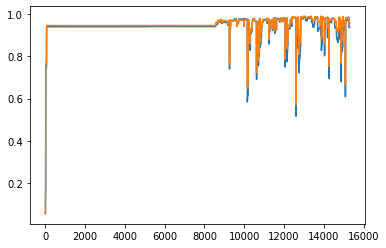

In [60]:
#here we define the gradient descent and the stochastic gradient descent with backtracking line search (to get an optimal learning rate)


epsilon = 10**-4
eta = 0.1

def backtracking_line_search (f, x, delta_x, grd_x, alpha= 0.25, beta=0.89):
    t = 1
    while (f(x+t*delta_x) >= f(x) + alptha*t*np.transpose(grd_x)@delta_x):
        t *= beta
    return t

def gradient_descent (f, grd, starting_point, classifier, eta = eta, epsilon = epsilon, learning_rate_function = backtracking_line_search):
    theta = starting_point
    prev_theta = starting_point
    r = f(theta, training_data, training_labels)
    test_errors, training_errors = [], []
    while True:
        test_errors.append(test(theta, test_data, test_labels, classifier))
        training_errors.append(test(theta, training_data, training_labels, classifier))
        prev_theta = theta
        f_theta, delta_theta = r, -grd(theta, training_data, training_labels)
        theta += eta*delta_theta#learning_rate_function(lambda x: regression_sum(x, train_data_gen, f), theta, delta_theta, -delta_theta)*
        r = f(theta, training_data, training_labels)
        print(r - f_theta)
        if (np.absolute(r - f_theta) < epsilon):
            test_errors.append(test(theta, test_data, test_labels, classifier))
            training_errors.append(test(theta, training_data, training_labels, classifier))
            break;
    return theta, test_errors, training_errors


def stochastic_gradient_descent (f, grd, starting_point, classifier, eta = eta, epsilon=epsilon, learning_rate_function = backtracking_line_search) :
    theta = starting_point
    prev_theta = starting_point
    r = f(theta, training_data, training_labels)
    test_errors, training_errors = [], []
    for x, y in zip(training_data, training_labels):
        x = np.reshape(x, (1,784))
        while True:
            test_errors.append(test(theta, test_data, test_labels, classifier))
            training_errors.append(test(theta, training_data, training_labels, classifier))
            prev_theta = theta
            f_theta, delta_theta = r, -grd(theta, x, y)
            theta += eta*delta_theta#learning_rate_function(lambda t: f(t, x, y), theta, delta_theta, -delta_theta)*
            r = f(theta, x, y)
            print(r - f_theta)
            if (np.absolute(r - f_theta) < epsilon):
                test_errors.append(test(theta, test_data, test_labels, classifier))
                training_errors.append(test(theta, training_data, training_labels, classifier))
                break;
    return theta, test_errors, training_errors
    

theta, a, b = stochastic_gradient_descent(logistic_loss, logistic_gradient, np.random.uniform(0, 1, (28*28, 1)), 
                               logistic_classify)

plot(b, a, np.arange(len(b)))
#accuracy = 0
#for x, y in zip(test_data, test_labels):
#    accuracy += (square_classify(theta, x) == y) 
    
#print(accuracy)

In [58]:
def k_nn_one_example (example, k, x, y, distance_function):
    x_training = x
    distances = distance_function(x_training, example)
    #print(distances)
    labels = y[np.argsort(x_training)[:k]]
    return 2*(np.sum(labels) > 0) -1

def KNN (k, data, labels, unlabeled_data, distance_function):
    return np.apply_along_axis(k_nn_one_example, 1, unlabeled_data, k, data, labels, distance_function)
    

def l_2_distance(X, y): 
    return np.sqrt(np.sum((X - y)**2, axis=1))

#def crossvalidation(data, labels, crossvalidation_percentage )

a = KNN (5, training_data, training_labels, test_data, l_2_distance)
print(a==test_labels)
print(sum(a==test_labels))
print(test_labels[0])

KeyboardInterrupt: 